In [11]:
from os.path import join
import os

import numpy as np
import pandas as pd
import pathlib
import torch
from pytorch_fid.fid_score import compute_statistics_of_path, calculate_frechet_distance, calculate_activation_statistics
from pytorch_fid.inception import InceptionV3
import matplotlib.pyplot as plt
import seaborn as sns
from config import CYCLE_GAN_DIR_RESULTS, DATASET_TEST_B

sns.set_theme()

plt.rcParams["figure.figsize"] = (16, 9)

In [12]:
num_avail_cpus = len(os.sched_getaffinity(0))
num_workers = min(num_avail_cpus, 8)
batch_size = 50

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')

dims = 2048
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = InceptionV3([block_idx]).to(device)

/home/ayk/miniconda3/envs/nir-coloring/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ayk/miniconda3/envs/nir-coloring/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
def calculate_fid_for_file_list(result_files, ground_truth_stat):
    m1, s1 = ground_truth_stat
    m2, s2 = calculate_activation_statistics(sorted(result_files), model, batch_size=batch_size, device=device,
                                             num_workers=num_workers)
    return calculate_frechet_distance(m1, s1, m2, s2)

In [14]:
inception_values_files = join(DATASET_TEST_B, "inception-values.npz")
if os.path.exists(inception_values_files):
    m1, s1 = compute_statistics_of_path(inception_values_files, model, dims=dims, batch_size=batch_size, device=device,
                                        num_workers=num_workers)
else:
    m1, s1 = compute_statistics_of_path(DATASET_TEST_B, model, dims=dims, batch_size=batch_size, device=device,
                                        num_workers=num_workers)
    np.savez(inception_values_files, mu=m1, sigma=s1)

In [15]:
NETWORK_NAME_MAP = {
    "nir_cyclegan_unet_ralsgan_sampling": "Verbessertes Sampling",
    "nir_cyclegan_unet_ralsgan_sampling_ssim": "SSIM",
    "nir_cyclegan_unet_ralsgan_sampling_ssim_ttur": "TTUR",
    "nir_cyclegan_unet_ralsgan_sampling_ssim_ttur_2_cyc": "Verbessertes Cycle Consistency",
    "nir_cyclegan_unet_ralsgan_sampling_ssim_ttur_2_cyc_spectral_normalization":"Spectral Normalization",
    "nir_cyclegan_unet_ralsgan_sampling_ssim_ttur_2_cyc_spectral_normalization_reduced_cycle":"Spectral Normalization (geringeres $\lambda$)",
    "cut":"CUT",
    "nir_cyclegan_unet_ralsgan_sampling_ssim_ttur_2_cyc_spectral_normalization_reduced_cycle_detach":"Detach Fix"
}

def map_epoch_name(name):
    name = name.removeprefix("test_")
    if name == "latest":
        return 200
    return int(name)

def map_network_name(name):
    if name in NETWORK_NAME_MAP.keys():
        return NETWORK_NAME_MAP[name]
    return name


results = []

for network_name in os.listdir(CYCLE_GAN_DIR_RESULTS):
    network_dir = join(CYCLE_GAN_DIR_RESULTS, network_name)
    for epoch_result in os.listdir(network_dir):
        epoch_result_dir = pathlib.Path(join(network_dir, epoch_result, "images"))

        if network_name.startswith("cut"):
            glob = epoch_result_dir.glob("fake_B/*.png")
        else:
            glob = epoch_result_dir.glob("*_fake.png")
        fid = calculate_fid_for_file_list(glob, (m1, s1))
        results.append([map_network_name(network_name), map_epoch_name(epoch_result), fid])

df = pd.DataFrame(results, columns=["Network", "Epoch", "FID"])
df

100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


,Network,Epoch,FID
0,nir_cyclegan_unet_ralsgan,200,349.801837
1,nir_cyclegan_unet_ralsgan,160,355.561217
2,CUT,80,326.321599
3,CUT,120,247.182466
4,CUT,320,204.437229
5,CUT,40,263.916605
6,CUT,160,231.438498
7,CUT,360,207.620971
8,CUT,240,241.785786
9,CUT,400,211.639572


In [16]:
df.groupby(by=["Network", "Epoch"]).min()

FID
Network                                        Epoch            
CUT                                            40     263.916605
                                               80     326.321599
                                               120    247.182466
                                               160    231.438498
                                               200    251.449058
                                               240    241.785786
                                               280    229.064256
                                               320    204.437229
                                               360    207.620971
                                               400    211.639572
Detach Fix                                     40     251.625676
                                               80     234.084303
                                               120    234.689384
                                               160    203.152041
                                               200    205.519866
SSIM                                           40     206.794514
                                               80     217.829858
                                               120    202.730019
                                               160    220.200548
                                               200    194.514303
Spectral Normalization                         40     268.210708
                                               80     231.000926
                                               120    217.612851
                                               160    238.773919
                                               200    203.985986
Spectral Normalization (geringeres $\lambda$)  40     229.467183
                                               80     216.314987
                                               120    211.627930
                                               160    205.013913
                                               200    199.880250
TTUR                                           40     220.517748
                                               80     288.088989
                                               120    220.964202
                                               160    226.210998
                                               200    212.068233
Verbessertes Cycle Consistency                 40     304.006494
                                               80     245.902356
                                               120    221.840620
                                               160    201.802817
                                               200    195.155896
Verbessertes Sampling                          80     253.136064
                                               160    243.590184
                                               200    206.377044
nir_cyclegan                                   100    216.138536
                                               200    227.666733
nir_cyclegan_unet                              200    235.390834
nir_cyclegan_unet_ralsgan                      160    355.561217
                                               200    349.801837
nir_cyclegan_unet_ralsgan_sampling_ssim_ttur_2 40     281.907747
                                               80     208.360398
                                               120    210.372092
                                               160    237.049812
                                               200    208.906601

In [17]:
df = df.sort_values(by=["Network", "Epoch"])
df

,Network,Epoch,FID
5,CUT,40,263.916605
2,CUT,80,326.321599
3,CUT,120,247.182466
6,CUT,160,231.438498
10,CUT,200,251.449058
8,CUT,240,241.785786
11,CUT,280,229.064256
4,CUT,320,204.437229
7,CUT,360,207.620971
9,CUT,400,211.639572


In [18]:
comparable_networks = [
    "Verbessertes Cycle Consistency",
    "Spectral Normalization",
    "Spectral Normalization (geringeres $\lambda$)",
    "Detach Fix",
    "CUT"
]
epoch_per_network_fid = df[df["Network"].isin(comparable_networks)].groupby(by=["Epoch", "Network"]).min()
epoch_per_network_fid = epoch_per_network_fid.sort_index()
epoch_per_network_fid: pd.DataFrame = epoch_per_network_fid.reset_index()
epoch_per_network_fid

,Epoch,Network,FID
0,40,CUT,263.916605
1,40,Detach Fix,251.625676
2,40,Spectral Normalization,268.210708
3,40,Spectral Normalization (geringeres $\lambda$),229.467183
4,40,Verbessertes Cycle Consistency,304.006494
5,80,CUT,326.321599
6,80,Detach Fix,234.084303
7,80,Spectral Normalization,231.000926
8,80,Spectral Normalization (geringeres $\lambda$),216.314987
9,80,Verbessertes Cycle Consistency,245.902356


<AxesSubplot:title={'center':'FID der Test Ergebnisse pro Epoche'}, xlabel='Epoche', ylabel='FID'>

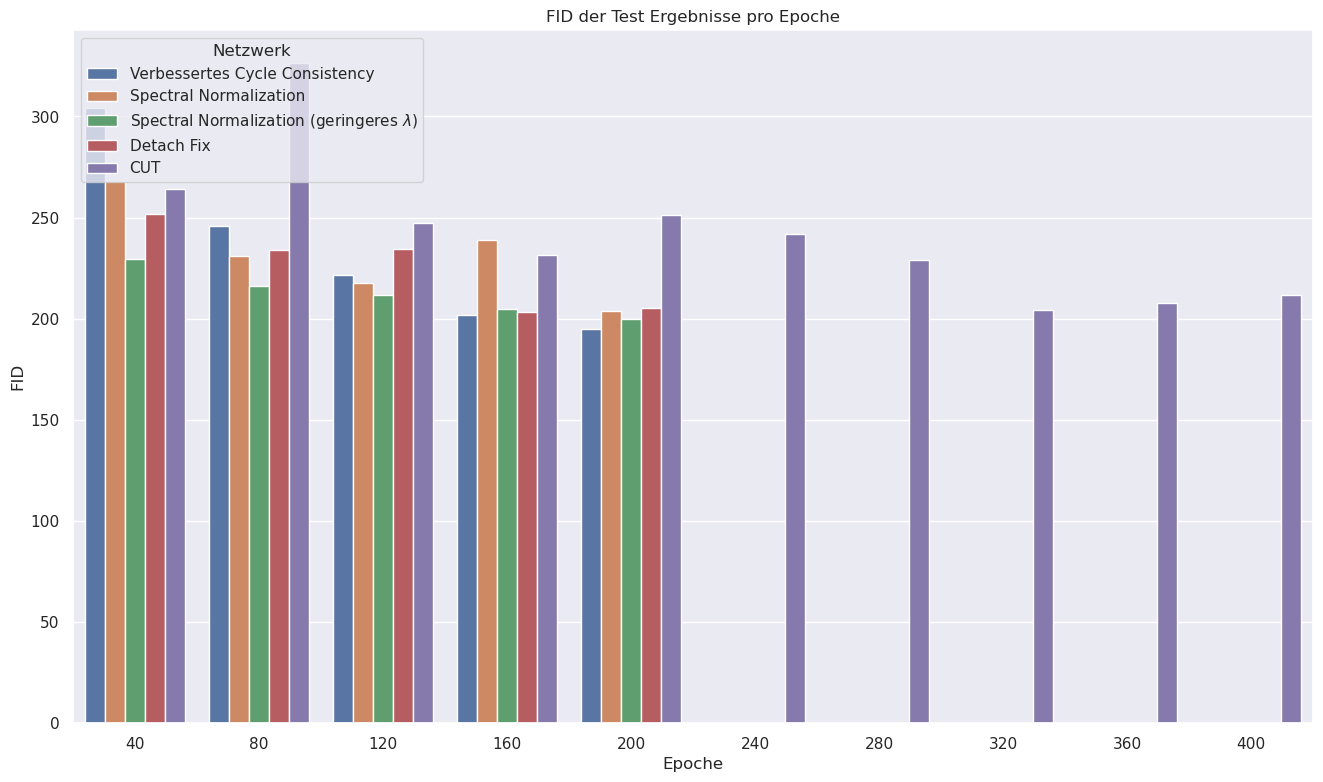

In [19]:
epoch_per_network_fid = epoch_per_network_fid.rename(columns={"Network": "Netzwerk", "Epoch":"Epoche"})
plt.title("FID der Test Ergebnisse pro Epoche")
sns.barplot(x="Epoche", y="FID", hue="Netzwerk", data=epoch_per_network_fid, hue_order=comparable_networks)

Text(0, 0.5, '$\\lambda$')

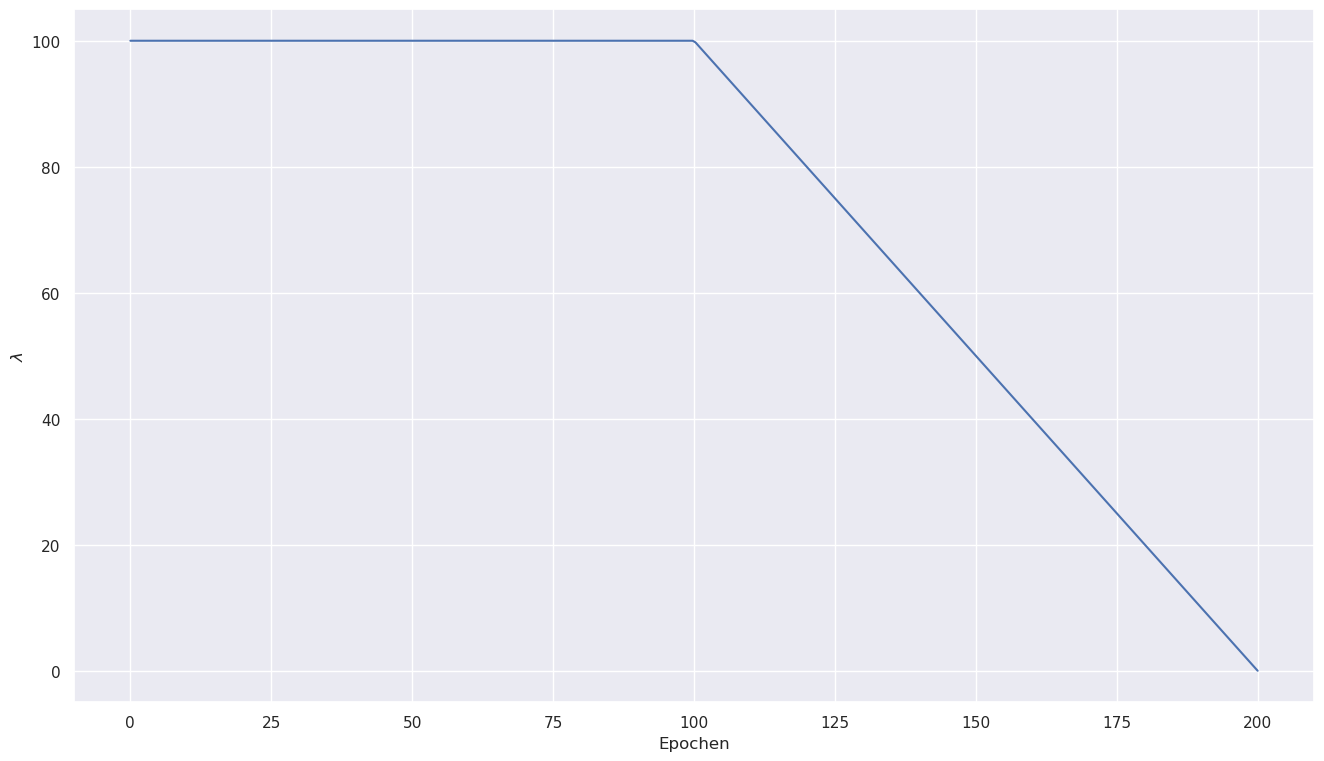

In [20]:
x = np.linspace(0, 200, num=400)
y = np.minimum(-1 * x + 200, 100)

ax: plt.Axes = sns.lineplot(x=x, y=y)
ax.set_xlabel("Epochen")
ax.set_ylabel("$\lambda$")